In [27]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import ot

In [28]:
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean
from scipy.stats import dirichlet, multivariate_normal

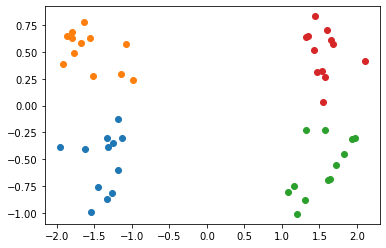

In [29]:
x1 = multivariate_normal.rvs(size=(12,2)) / 4
x2 = multivariate_normal.rvs(size=(12,2)) / 4
x3 = multivariate_normal.rvs(size=(12,2)) / 4
x4 = multivariate_normal.rvs(size=(12,2)) / 4

x1 += np.array([-1.5,-0.5])
x2 += np.array([-1.5,0.5])
x3 += np.array([1.5,-0.5])
x4 += np.array([1.5,0.5])

plt.scatter(x1[:,0], x1[:,1])
plt.scatter(x2[:,0], x2[:,1])
plt.scatter(x3[:,0], x3[:,1])
plt.scatter(x4[:,0], x4[:,1])

In [30]:
def prune(Xs, threshold, distance):
    """
    prune removes all points that are more than the threshold away from every
    point in every other color
    
    :param: list of datasets of points
    :param threshold: location of the hard threshold
    :param distance: distance function to compute pairwise distances
    :return: two datasets, containing non-isolated and isolated points resp.
    """
    
    close_Xs = []
    far_Xs = []
    
    # iterate over each class splitting the datasets
    for i in range(len(Xs)):
        Xi = Xs[i]
        
        # has_close[i] will be 0 if it has no nearby points, pos. o.w.
        has_close = np.zeros(Xi.shape[0])
        
        # compare against each other class
        for j in range(len(Xs)):
            if i == j: 
                continue
            
            # computes thresholded cost
            cost = cdist(Xi,Xs[j], metric=distance) <= threshold*2
            
            # and adds the indicators 
            has_close += np.sum(cost, axis=1)
            
        # convert to True-False
        has_close = has_close > 0
        close_inds = np.where(has_close)[0]
        far_inds = np.where(1-has_close)[0]
        
        close_Xs += [Xi[close_inds]]
        far_Xs += [Xi[far_inds]]
        
    return close_Xs, far_Xs

In [31]:
def generate_cost(X, Y, threshold, distance, barrier=1):
    """
    generate_cost given a pair of datapoints, gives a soft approximation to
    the indicator cost.
    
    :param X: first dataset of points
    :param Y: second dataset of points
    :param threshold: location of the soft threshold
    :param distance: distance function to compute pairwise distances
    :param barrier: parameter determining how hard the threshold should be
    :return: cost matrix approximating the indicator 
    """
    base_cost = cdist(X,Y, metric=distance)
    cost = np.exp(barrier*(base_cost - threshold))
    return cost

In [32]:
def generate_cost_move_far(X, Y, threshold, distance, barrier=1, slope=1):
    """
    generate_cost given a pair of datapoints, gives a soft approximation to
    the indicator cost.
    
    :param X: first dataset of points
    :param Y: second dataset of points
    :param threshold: location of the soft threshold
    :param distance: distance function to compute pairwise distances
    :param barrier: parameter determining how hard the threshold should be
    :param slope: slope to use to encourage moving far away
    :return: cost matrix approximating the indicator 
    """
    base_cost = cdist(X,Y, metric=distance)
    cost = (np.exp(barrier *(base_cost - threshold)) + 5 * threshold) * (base_cost > threshold) \
        - slope*base_cost * (base_cost <= threshold)
    return cost

In [33]:
def solve_partial_ots(Xs, Xmasses, Y, Ymass, threshold, distance, barrier=1, slope=0):
    """
    solve_partial_ots given a set of source distributions and a shared target
    computes the partial transport from each source to the target
    
    :param Xs: list of dataset of points
    :param Xmasses: amount of mass at each point. Xmasses[i] is a ~scalar~
    :param Y: second dataset of points
    :param Ymass: amount of mass at each point in Y
    :param threshold: location of the soft threshold
    :param distance: distance function to compute pairwise distances
    :param barrier: parameter determining how hard the threshold should be
    :param slope: slope for encouraging mass to move far, if this is 0
        then the soft barrier cost is used
    :return: list of partial couplings
    """
    
    gammas = []
    for X, mass in zip(Xs, Xmasses):
        Xmass = np.ones(X.shape[0]) * mass
        if slope == 0:
            cost = generate_cost(X, Y, threshold, distance, barrier=barrier)
        else:
            cost = generate_cost_move_far(X, Y, threshold, distance, barrier=barrier, slope=slope)
        gammas += [ot.partial.partial_wasserstein(Xmass, Ymass, cost, m=np.sum(Xmass), nb_dummies=10)]
        
    return gammas

In [34]:
def solve_partial_ot(X, Xmass, Y, Ymass, threshold, distance, Y_uses, barrier=1, slope=0, reward=0):
    """
    solve_partial_ots given a set of source distributions and a shared target
    computes the partial transport from each source to the target
    
    :param X: dataset of points
    :param Xmass
    :param Y: second dataset of points
    :param Ymass: amount of mass at each point in Y
    :param threshold: location of the soft threshold
    :param distance: distance function to compute pairwise distances
    :param barrier: parameter determining how hard the threshold should be
    :param slope: slope for encouraging mass to move far, if this is 0
        then the soft barrier cost is used
    :return: list of partial couplings
    """
    
    Xmass = np.ones(X.shape[0]) * Xmass
    if slope == 0:
        cost = generate_cost(X, Y, threshold, distance, barrier=barrier)
    else:
        cost = generate_cost_move_far(X, Y, threshold, distance, barrier=barrier, slope=slope)
    cost -= reward * Y_uses.sum(1) # don't add a reward for points beyond threshold.
    
    gamma = ot.partial.partial_wasserstein(Xmass, Ymass, cost, m=np.sum(Xmass), nb_dummies=10)
        
    return gamma

In [35]:
def update_Y_locations(Xs, Y, gammas, Y_uses=None, interpolation=0.1):
    """
    update_Y_locations moves the locations of the points in Y to the 
    centroids of the mass being assigned to them
    
    :param Xs: list of dataset points
    :param Y: second dataset of points to be updated
    :param gammas: partial couplings
    :param Y_uses: 2D boolean array for if Y_uses[i,j] is if the i'th Y point
        is used by the j'th color.
    :return: updated locations as well as the updated mass assignments
    """
    
    # gets the amount of mass assigned to every point summed over
    # all of the classes
    total_assignment = np.sum(gammas, axis=(0,1))
    
    # shifts each point used in Y to the average of the points using it
    centroids = np.zeros(Y.shape)
    for (X,gamma) in zip(Xs, gammas):
        centroids += gamma.T @ X
    centroids /= total_assignment[:,np.newaxis] + 0.00000001
    
    # finds how much mass must be placed on each point in order that
    # Y dominates the transformed Xs
    dominating_mass = np.max(np.sum(gammas, axis=1), axis=0)
    
    # removes unused points 
    centroids = (interpolation*centroids + (1-interpolation)*Y)[total_assignment > 0]
    dominating_mass = dominating_mass[total_assignment > 0]
    
    if not Y_uses is None:
        new_uses = Y_uses[total_assignment > 0]
        return centroids, dominating_mass, new_uses
    
    return centroids, dominating_mass

In [36]:
def generate_initial_Y(Xs, npoints=40):
    """
    generate_initial_Y creates a reasonable set of starting points for the 
    adversary to work from.
    
    :param Xs: list of dataset points
    :param npoints: number of support points
    """
    
    # number of classes and dimension of data
    K = len(Xs)
    d = Xs[0].shape[1]
    
    # generates random coordinates to start from
    alpha = np.ones(K)
    coords = dirichlet.rvs(alpha, size=npoints)
    
    # each point in Y is a random convex combination of real data points
    Y = np.zeros((npoints, d))
    for i in range(npoints):
        for k in range(K):
            Y[i,:] += coords[i,k] * Xs[k][np.random.randint(Xs[k].shape[0]),:]
    
    return Y

In [132]:
def fixed_point(Xs, threshold, distance, npoints=50, num_iters=25, barrier=1, slope=0):
    """
    fixed_point given a set of measures, runs a fixed point approach to find
    the adversarial measure
    
    :param Xs: list of lists of datapoints, one for each class 
    :param threshold: location of the soft threshold
    :param distance: distance function to compute pairwise distances
    :param npoint: number of support points to start the adversary with
    :param num_iters: number of fixed point iterations to run for
    :param barrier: parameter determining how hard the threshold should be
    :param slope: slope for encouraging mass to move far, if this is 0
        then the soft barrier cost is used
    :return: the support, mass, assignments for the dominating measure
        and re-ordered Xs
    """
    
    Xmasses = [1 / len(X) for X in Xs]
    close_Xs, far_Xs = prune(Xs, threshold, distance)
    
    # generates the initial setting of Y measure
    K = len(Xs)
    Y = generate_initial_Y(close_Xs, npoints=npoints)
    Ymass = np.ones(npoints) 
    
    # applies the fixed point updates 
    for i in range(num_iters):
        # solve the partial optimal transports
        gammas = solve_partial_ots(close_Xs, Xmasses, Y, Ymass, threshold, distance, \
                                   barrier=barrier, slope=slope)
        
        # and uses those to update the measure
        Y,Ymass = update_Y_locations(close_Xs, Y, gammas)
        
    # rebuilds the Ys with the pruned support added back in
    Y = np.concatenate([Y]+far_Xs)
    Ymass = np.concatenate([Ymass]+[np.ones(len(cX))*m for cX,m in zip(far_Xs, Xmasses)])
    
    # rebuilds the gammas with the mass put back in
    full_gammas = []
    npoints = np.sum([len(X) for X in Xs])
    start_index = 1
    for k in range(K):
        
        fg = np.zeros((len(Xs[k]), len(Ymass)))
        # copy over the original gamma
        fg[0:gammas[k].shape[0], 0:gammas[k].shape[1]] = gammas[k]
        
        # add in the extra part for far points
        start = gammas[k].shape[1]+start_index-1
        end = start+len(far_Xs[k])
        start_index += len(far_Xs[k])
        
        fg[len(close_Xs[k]):, start:end] = np.eye(end-start) / len(Xs[k])
        
        full_gammas += [fg]
        
    # rebuilds the support of the Xs
    rebuild_Xs = [np.concatenate([close_X, far_X]) for close_X, far_X in zip(close_Xs, far_Xs)]
    
    # the last gammas are useful for figuring out what the source is being moved to.
    return Y, Ymass, full_gammas, rebuild_Xs

In [133]:
def incentive_fixed_point(Xs, threshold, distance, npoints, num_iters=100, 
                          barrier=1, slope=0, reward=-1):
    """
    incentive_fixed_point given a set of measures, runs a fixed point approach with 
    encouragement for using points that are being used by other classes
    :param Xs: list of lists of datapoints, one for each class 
    :param threshold: location of the soft threshold
    :param distance: distance function to compute pairwise distances
    :param npoint: number of support points to start the adversary with
    :param num_iters: number of fixed point iterations to run for
    :param barrier: parameter determining how hard the threshold should be
    :param slope: slope for encouraging mass to move far, if this is 0
        then the soft barrier cost is used
    :param reward: amount to reduce the cost by if the point is being used
    :return: the support, mass, assignments for the dominating measure
        and re-ordered Xs
    """
    
    Xmasses = [1/len(X) for X in Xs]
    close_Xs, far_Xs = prune(Xs, threshold, distance)
    
    # generates the initial setting of Y measure
    K = len(Xs)
    Y = generate_initial_Y(close_Xs, npoints=npoints)
    Ymass = np.ones(npoints) 
    Y_uses = np.zeros((npoints, K))
    
    # applies the fixed point updates 
    for i in range(num_iters):
        
        gammas = []
        for j in range(K):
            
            Y_uses[:,j] = 0
            gamma = solve_partial_ot(close_Xs[j], Xmasses[j], Y, Ymass, threshold, distance, Y_uses, \
                                     barrier=barrier, slope=slope, reward=reward)
            Y_uses[:,j] = gamma.sum(0) > 0
            gammas += [gamma]
        
        # and uses those to update the measure
        Y, Ymass, Y_uses = update_Y_locations(close_Xs, Y, gammas, Y_uses=Y_uses)
    
    # rebuilds the Ys with the pruned support added back in
    Y = np.concatenate([Y]+far_Xs)
    Ymass = np.concatenate([Ymass]+[np.ones(len(cX))*m for cX,m in zip(far_Xs, Xmasses)])
    
    # rebuilds the gammas with the mass put back in
    full_gammas = []
    npoints = np.sum([len(X) for X in Xs])
    start_index = 1
    for k in range(K):
        
        fg = np.zeros((len(Xs[k]), len(Ymass)))
        # copy over the original gamma
        fg[0:gammas[k].shape[0], 0:gammas[k].shape[1]] = gammas[k]
        
        # add in the extra part for far points
        start = gammas[k].shape[1]+start_index-1
        end = start+len(far_Xs[k])
        start_index += len(far_Xs[k])
        
        fg[len(close_Xs[k]):, start:end] = np.eye(end-start) / len(Xs[k])
        
        full_gammas += [fg]
        
    # rebuilds the support of the Xs
    rebuild_Xs = [np.concatenate([close_X, far_X]) for close_X, far_X in zip(close_Xs, far_Xs)]
    
    # the last gammas are useful for figuring out what the source is being moved to.
    return Y, Ymass, full_gammas, rebuild_Xs

In [134]:
def violating_mass(Xs, Y, gammas, threshold, distance):
    """
    violating_mass computes how much mass from the Xs are moved too far to
    get to a Y point based on the threshold and the distance function.
    
    :param Xs: list of lists of datapoints, one for each class 
    :param Y: support of the barycenter measure
    :param threshold: maximum movement distance
    :param distance: distance function
    :return: total amount of mass across all classes moving to far
    """
    
    total_violation = 0
    for X,gamma in zip(Xs, gammas):
        base_cost = cdist(X,Y, metric=distance)
        binary_cost = base_cost > threshold
        total_violation += np.sum(binary_cost * gamma)
        
    return total_violation

In [137]:
threshold = 0.3
Y, Ymass, gammas, Xs = fixed_point(
    data, threshold, euclidean,
    npoints=50, barrier=3, slope=1.0)
#plt.scatter(Y[:,0], Y[:,1])
print('\n',np.sum(Ymass))
print(violating_mass(Xs, Y, gammas, threshold, euclidean))


 2.916666666666663
0.1666666666666778


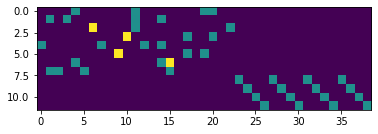

In [130]:
plt.imshow(gammas[3]+gammas[2]+gammas[1]+gammas[0])

In [91]:
Ymass.shape

(54,)

In [47]:
data[1].shape

(12, 2)

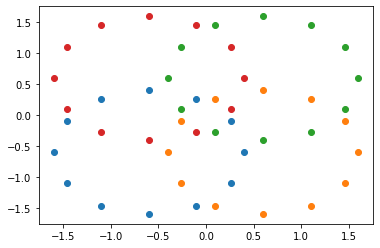

In [14]:
n = 12
linspace = np.arange(n)
circle = np.vstack([np.cos(linspace / n * 2 * np.pi), np.sin(linspace / n * 2 * np.pi)]).T
data = [
    circle + np.array([-0.6,-0.6]),
    circle + np.array([0.6,-0.6]),
    circle + np.array([0.6,0.6]),
    circle + np.array([-0.6,0.6]),
]
for d in data:
    plt.scatter(d[:,0],d[:,1])

In [148]:
Y.shape

(24, 2)

In [149]:
Ymass.sum()

3.374999999999999

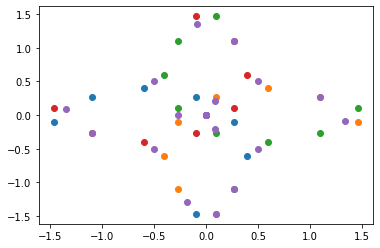

In [257]:
for X in close_Xs:
    plt.scatter(X[:,0], X[:,1])
plt.scatter(Y[:,0], Y[:,1])

In [158]:
gammas[0].sum(0) > 0

array([False, False,  True, False, False, False, False,  True,  True,
        True, False,  True, False,  True,  True, False,  True, False,
        True, False,  True, False,  True, False])